In [1]:
from skimage.io import imread, imshow
import numpy as np
import os
import random

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
im_path = '/media/instadeeprd/DATA/Instadeep_projects/Total/BU_13B_A_2um_GT_X1600_Y1600_Z1600_uint8.tif'

In [3]:
img_ = imread(im_path)

/home/instadeeprd/miniconda3/envs/image/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


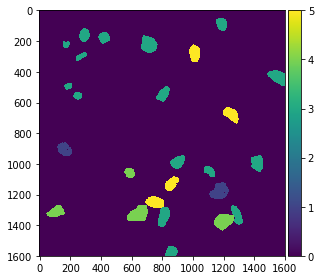

In [4]:
imshow(img_[10,:,:])

/home/instadeeprd/miniconda3/envs/image/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


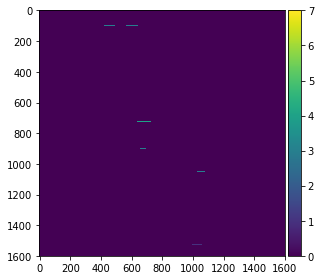

In [5]:
imshow(img_[:,10,:])

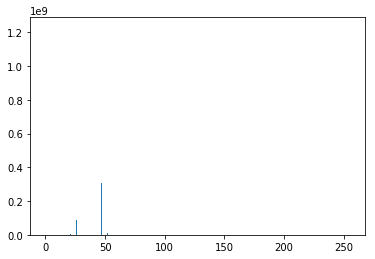

In [5]:
im_path = '/media/instadeep/DATA/projects/cube_13B/BU_645_13B_A_2um_uchar_1600x1600x1600.tif'
img_ = imread(im_path)
# print(img_.max())
# print(img_.min())
plt.hist(img_.flatten(), bins='auto')
plt.show()

In [12]:
class Data_Generator(object):
    def __init__(self, path_image, path_mask, batch_size):
        self.path_image = path_image
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.IMG_CHANNELS = 1
    def generator(self):
        image = imread(self.path_image)
        mask = imread(self.path_mask)
        self.IMG_HEIGHT, self.IMG_WIDTH = image[0,:,:].shape
        
        list_idx = []
        for k in range(len(image)):
            if len(np.nonzero(mask[k,:,:])[0]):
#                 print('Choosen mask', mask[k,:,:].max(),mask[k,:,:].min())
                list_idx.append(k)
        while 1:
            img = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
            msk = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, 1))
            for idx in range(self.batch_size):
                s_idx = random.choice(list_idx)
                img[idx,:,:,0] = image[s_idx]
                msk[idx,:,:,0] = mask[s_idx]
            msk[msk>0] = 1
            yield img, msk

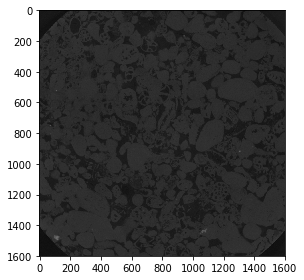

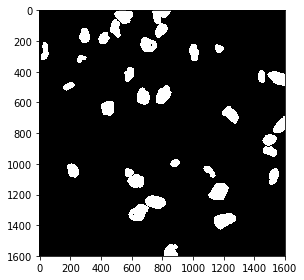

In [14]:
training_generator = Data_Generator('/media/instadeeprd/DATA/Instadeep_projects/Total/image_fossil/BU_645_13B_A_2um_uchar_1600x1600x1600.tif', '/media/instadeeprd/DATA/Instadeep_projects/Total/BU_13B_A_2um_GT_X1600_Y1600_Z1600_uint8.tif', 4)
for img, mask in training_generator.generator():
#     print(img.shape)
#     print(img.max(), img.min())
#     print(mask.shape)
#     print(mask.max(), mask.min())
    imshow(img[2,:,:,0],cmap='gray')
    plt.show()
    imshow(mask[2,:,:,0],cmap='gray')
    plt.show()
    break

In [52]:
import numpy as np
import os
import random

from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize, rotate
from skimage.filters import gaussian
from skimage.morphology import label
from matplotlib import pyplot as plt
%matplotlib inline

class Data_Generator_from_cube(object):
    def __init__(self, path_image, path_mask, batch_size, n_channel, n_class, convert_1class=False):
        self.path_image = path_image
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.n_channel = n_channel
        self.n_class = n_class
        self.convert_1class = convert_1class

    def transformer(self, s_idx):
        angl = random.choice([0, 90, 180, 270])
        blr = random.choice([0, 1, 2, 3])
        flp = random.choice(['n', 'v', 'h'])
        
        img = self.image[s_idx] 
        mask = self.mask[s_idx]
        
#         imshow(mask, cmap='gray')
#         plt.show()
        img = gaussian(img, blr)
        # mask = gaussian(mask, blr)

        img = rotate(img, angl)
        mask = rotate(mask, angl)

        if flp == 'v':
            img = np.flipud(img)
            mask = np.flipud(mask)
        elif flp == 'h':
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        
        img = np.rint(img*255)
        img[img>255] = 255
        img[img<0] = 0
        img = img.astype(np.uint8)
        
        mask = np.rint(mask*255)
        mask[mask>255] = 255
        mask[mask<0] = 0
        mask = mask.astype(np.uint8) 
        
        return img, mask

    def generator(self):
        self.image = imread(self.path_image)
        
#         self.mask = imread(self.path_mask)
        self.mask = np.fromfile(self.path_mask, dtype=np.uint8).reshape((1600,1600,1600))
        self.mask[self.mask == 7] = 0
        self.mask[self.mask == 6] = 0
        
        if self.convert_1class:
            self.mask[self.mask > 0] = 1
            self.n_class = 1

        self.IMG_HEIGHT, self.IMG_WIDTH = self.image[0,:,:].shape
        
        list_idx = []
        for k in range(len(self.image)):
            if len(np.nonzero(self.mask[k,:,:])[0]):
                list_idx.append(k)
        print('Nombre de coupe avec fossil: ', len(list_idx))
        
        while 1:
            img = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_channel), dtype=np.uint8)
            msk = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_class), dtype=np.uint8)
            for idx in range(self.batch_size):
                s_idx = random.choice(list_idx)
                img_, mask_ = self.transformer(s_idx)
                img[idx,:,:,0] = img_ # We should replace 0 by the appropriate param (generalize to color) 
                
#                 imshow(mask_, cmap='gray')
#                 plt.show()
                
                for cls in range(0, self.n_class):
                    class_mask = np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH), dtype=np.uint8)
                    class_mask[mask_==cls+1] = 1
                    msk[idx,:,:, cls] = class_mask
          
            yield img, msk

In [1]:
import numpy as np
import os
import random


from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize, rotate
from skimage.filters import gaussian
from skimage.morphology import label

from matplotlib import pyplot as plt
%matplotlib inline

class Data_Generator_from_cube(object):
    def __init__(self, path_image, path_mask, batch_size, n_channel, n_class, convert_1class=False):
        self.path_image = path_image
        self.path_mask = path_mask
        self.batch_size = batch_size
        self.n_channel = n_channel
        self.n_class = n_class
        self.convert_1class = convert_1class

    def transformer(self, s_idx):
        angl = random.choice([0, 90, 180, 270])
        blr = random.choice([0, 1, 2, 3])
        flp = random.choice(['n', 'v', 'h'])
        
        img = self.image[s_idx] 
        mask = self.mask[s_idx]
        
        img = gaussian(img, blr)
        # mask = gaussian(mask, blr)

        img = rotate(img, angl)
        mask = rotate(mask, angl)

        if flp == 'v':
            img = np.flipud(img)
            mask = np.flipud(mask)
        elif flp == 'h':
            img = np.fliplr(img)
            mask = np.fliplr(mask)
        
        img = np.rint(img*255)
        img[img>255] = 255
        img[img<0] = 0
        img = img.astype(np.uint8)
        
        mask = np.rint(mask*255)
        mask[mask>255] = 255
        mask[mask<0] = 0
        mask = mask.astype(np.uint8) 
        
        return img, mask

    def generator(self):
        self.image = imread(self.path_image)
        # self.mask = imread(self.path_mask)
        self.mask = np.fromfile(self.path_mask, dtype=np.uint8).reshape((1600,1600,1600))
        self.mask[self.mask == 7] = 0
        self.mask[self.mask == 6] = 0
        if self.convert_1class:
            self.mask[self.mask > 0] = 1
            self.n_class = 1

        self.IMG_HEIGHT, self.IMG_WIDTH = self.image[0,:,:].shape
        
        list_idx = []
        for k in range(len(self.image)):
            if len(np.nonzero(self.mask[k,:,:])[0]):
                list_idx.append(k)
        while 1:
            img = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_channel), dtype=np.uint8)
            msk = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_class), dtype=np.uint8)
            for idx in range(self.batch_size):
                s_idx = random.choice(list_idx)
                img_, mask_ = self.transformer(s_idx)
                img[idx,:,:,0] = img_ # We should replace 0 by the appropriate param (generalize to color) 
                
                for cls in range(0, self.n_class):
                    class_mask = np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH), dtype=np.uint8)
                    class_mask[mask_==cls+1] = 1
                    msk[idx,:,:, cls] = class_mask
          
            yield img, msk

(1, 1600, 1600, 1)
(1, 1600, 1600, 5)
Show image


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


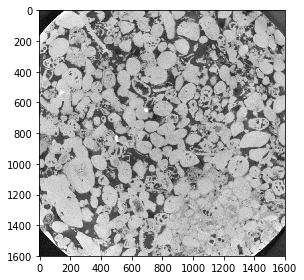

Show masks one by one


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


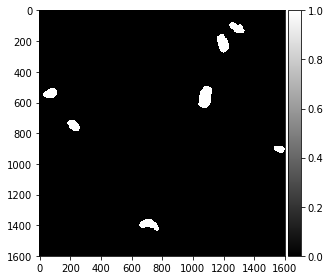

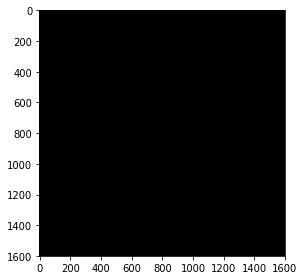

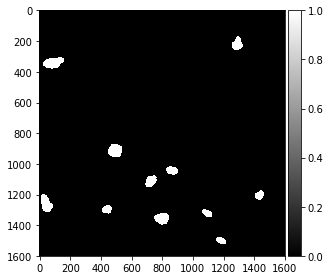

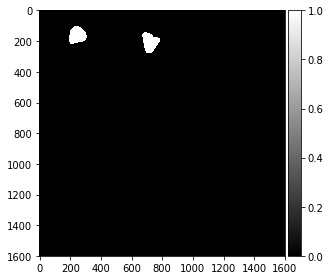

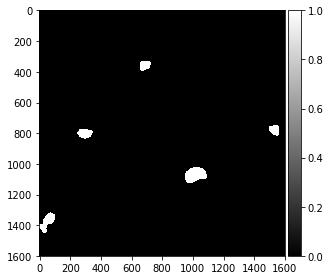

In [2]:
BATCH_SIZE = 1
IMAGE_CUBE = '/media/instadeep/DATA/projects/cube_13B/BU_13B_x1600_y1600_z1600.tif'
MASK_CUBE = '/media/instadeep/DATA/projects/cube_13B/masks_GT.raw'

training_generator = Data_Generator_from_cube(IMAGE_CUBE, MASK_CUBE, BATCH_SIZE, n_channel=1, n_class=5, convert_1class=False)
for img, mask in training_generator.generator():
    print(img.shape)
    print(mask.shape)
#     print(img[2,:,:,0].max())
#     print(img[2,:,:,0].min())
    print('Show image')
    imshow(img[0,:,:,0], cmap='gray')
    plt.show()
    print('Show masks one by one')
    for i in range(5):
#         print(mask[0,:,:,i].max())
#         print(mask[0,:,:,i].min())
#         imsave('slice' + str(i)+'.tif', mask[0,:,:,i])
#         print(mask.dtype)
        imshow(mask[0,:,:,i], cmap='gray')
        plt.show()
    break

In [ ]:
#Augment and Save to folder

import numpy as np
import os
import random


from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize, rotate
from skimage.filters import gaussian
from skimage.morphology import label


IMAGE_CUBE = '/media/instadeep/DATA/projects/cube_13B/BU_13B_x1600_y1600_z1600.tif'
MASK_CUBE = '/media/instadeep/DATA/projects/cube_13B/masks_GT.raw'

out_image = '/media/instadeep/DATA/projects/cube_13B/slices/image/'
out_mask = '/media/instadeep/DATA/projects/cube_13B/slices/annotation/'

image = imread(IMAGE_CUBE)
mask = np.fromfile(MASK_CUBE, dtype=np.uint8).reshape((1600,1600,1600))
mask[mask == 7] = 0
mask[mask == 6] = 0

list_idx = []
for k in range(len(image)):
    if len(np.nonzero(mask[k,:,:])[0]):
        list_idx.append(k)

In [7]:
angl = [0, 90, 180, 270]
blr = [0, 1, 2, 3]
flp = ['n', 'v', 'h']

i = 0
for idx in list_idx:
    image_ = image[idx] 
    mask_ = mask[idx]
    print('next slice')
    for ag in angl:
        for br in blr:
            for fp in flp:
                image_ = gaussian(image_, br)
                image_ = rotate(image_, ag)
                mask_ = rotate(mask_, ag)

                if fp == 'v':
                    image_ = np.flipud(image_)
                    mask_ = np.flipud(mask_)
                elif fp == 'h':
                    imimage_g = np.fliplr(image_)
                    mask_ = np.fliplr(mask_)

                image_ = np.rint(image_*255)
                image_[image_>255] = 255
                image_[image_<0] = 0
                image_ = image_.astype(np.uint8)

                mask_ = np.rint(mask_*255)
                mask_[mask_>255] = 255
                mask_[mask_<0] = 0
                mask_ = mask_.astype(np.uint8)
                
                imsave(out_image + 'slice' + str(idx) + '_blur' + str(br) + '_angle' + str(ag) + '_flip' + fp + '.png', image_)
                imsave(out_mask  + 'slice' + str(idx) + '_blur' + str(br) + '_angle' + str(ag) + '_flip' + fp + '.png', mask_)
                i += 1
                

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice10_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice20_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice25_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice26_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice30_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice40_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice50_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur1_angle0_flipn.png is a low 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice75_blur3_angle180_flipv.png i

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice100_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice125_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice150_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice175_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice200_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice225_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice250_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice275_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice300_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice325_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice350_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice375_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice400_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice425_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice450_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice475_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice500_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice525_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice550_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice575_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice600_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice625_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice650_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice675_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice700_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice725_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice750_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice775_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice800_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice825_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice850_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice875_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice900_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice925_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice950_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur1_angle0_flipn.png is a 

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice975_blur3_angle180_flipv.p

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1000_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1025_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1050_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1075_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1100_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1125_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1150_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1175_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1200_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1225_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1250_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1275_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1300_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1325_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1330_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1343_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1344_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1345_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1346_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1350_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1375_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1400_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1425_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1450_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1475_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1500_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1525_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1550_blur3_angle180_fli

next slice


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur0_angle0_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur0_angle0_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur0_angle0_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur1_angle0_flipn.png i

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur2_angle180_flipv.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur2_angle180_fliph.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur3_angle180_flipn.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: /media/instadeep/DATA/projects/cube_13B/slices/annotation/slice1575_blur3_angle180_fli

In [8]:
import os, random
from shutil import copyfile

IMAGE_PATH_TRAIN = '/media/instadeep/DATA/projects/cube_13B/slices/image/'
ANNO_PATH_TRAIN = '/media/instadeep/DATA/projects/cube_13B/slices/annotation/'

ids = os.listdir(IMAGE_PATH_TRAIN)

random.shuffle(ids)

for id_ in ids[0:2000]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/train/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/train/annotation/' + id_)
for id_ in ids[2000:3000]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/validation/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/validation/annotation/' + id_)
for id_ in ids[3000:3504]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/test/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/cube_13B/test/annotation/' + id_)
    


In [60]:
import numpy as np
import os
import random

from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize, rotate
from skimage.filters import gaussian
from skimage.morphology import label
from matplotlib import pyplot as plt
%matplotlib inline




batch_size = 1
IMAGE_CUBE = '../../cube_13B/BU_13B_x1600_y1600_z1600.tif'
MASK_CUBE = '/media/instadeep/DATA/projects/cube_13B/masks_GT.raw'





# mask = imread(MASK_CUBE)
mask = np.fromfile(MASK_CUBE, dtype=np.uint8).reshape((1600,1600,1600))
mask[mask == 7] = 0
mask[mask == 6] = 0

image = imread(IMAGE_CUBE)


IMG_HEIGHT, IMG_WIDTH = image[0,:,:].shape
        
list_idx = []
for k in range(len(image)):
    if len(np.nonzero(mask[k,:,:])[0]):
        list_idx.append(k)
print('Nombre de coupe avec fossil: ', len(list_idx))

Nombre de coupe avec fossil:  73


slice number :  1330
(1, 1600, 1600, 5)


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


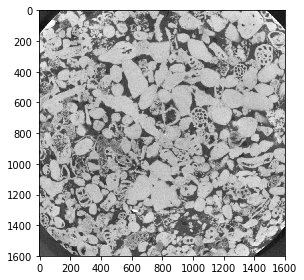

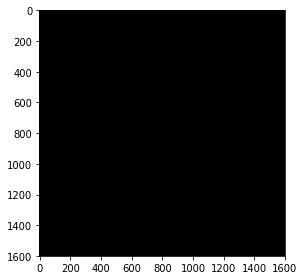

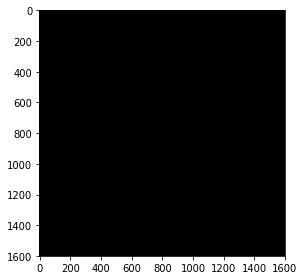

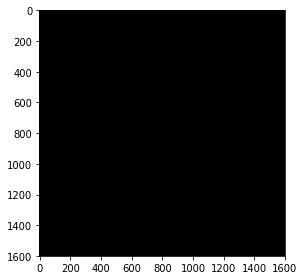

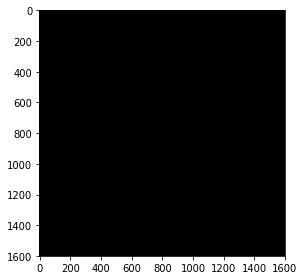

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


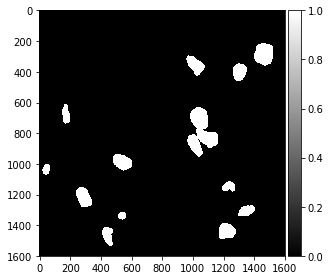

In [69]:
img = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
msk = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 5), dtype=np.uint8)

for idx in range(batch_size):
    s_idx = random.choice(list_idx)

    angl = random.choice([0, 90, 180, 270])
    blr = random.choice([0, 1, 2, 3])
    flp = random.choice(['n', 'v', 'h'])

    img_ = image[s_idx] 
    mask_ = mask[s_idx]

    img_ = gaussian(img_, blr)

    print('slice number : ', s_idx)
    
    img_ = rotate(img_, angl)
    mask_ = rotate(mask_, angl)
    
    if flp == 'v':
        img_ = np.flipud(img_)
        mask_ = np.flipud(mask_)
    elif flp == 'h':
        img_ = np.fliplr(img_)
        mask_ = np.fliplr(mask_)

    img_ = np.rint(img_*255)
    img_[img_>255] = 255
    img_[img_<0] = 0
    img_ = img_.astype(np.uint8)

    mask_ = np.rint(mask_*255)
    mask_[mask_>255] = 255
    mask_[mask_<0] = 0
    mask_ = mask_.astype(np.uint8) 
    
    
#     print(img.shape)
    img[idx,:,:,0] = img_
        
    for cls in range(0, 5):
        class_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        class_mask[mask_== cls+1] = 1
        msk[idx,:,:, cls] = class_mask
                    
print(msk.shape)
imshow(img[0,:,:,0], cmap='gray')
plt.show()

imshow(msk[0,:,:,0], cmap='gray')
plt.show()
imshow(msk[0,:,:,1], cmap='gray')
plt.show()
imshow(msk[0,:,:,2], cmap='gray')
plt.show()
imshow(msk[0,:,:,3], cmap='gray')
plt.show()
imshow(msk[0,:,:,4], cmap='gray')
plt.show()

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


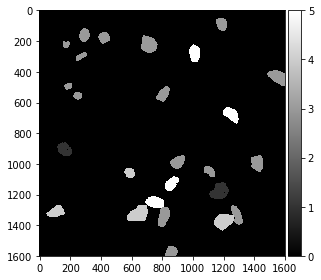

In [34]:
import numpy as np
img = np.fromfile('/media/instadeep/DATA/projects/cube_13B/masks_GT.raw', dtype=np.uint8).reshape((1600,1600,1600))
imshow(img[10], cmap='gray')
plt.show()

In [31]:
img = np.fromfile('../../cube_13B/BU_13B_x1600_y1600_z1600.tif', dtype=np.uint8).reshape((1600,1600,1600))
imshow(img[10], cmap='gray')
plt.show()

ValueError: cannot reshape array of size 4096201657 into shape (1600,1600,1600)

In [3]:
image = imread('mask.tif')
# print(image.shape)
angl = random.choice([0, 90, 180, 270])
blr = random.choice([0, 5, 10])
flp = random.choice(['n', 'v', 'h'])

maxmask = 7

imshow(image) #,cmap='gray')
plt.show()


img = rotate(image, angl)
# img = gaussian(image[:,:], 4)
print(img.max())
# img = np.fliplr(image)
# imshow(img) #,cmap='gray')
# plt.show()


mask = np.rint(img*255)
print(mask.max())
mask[mask>maxmask] = maxmask
mask[mask<0] = 0
mask = mask.astype(np.uint8)

print(mask.max())

NameError: name 'imread' is not defined

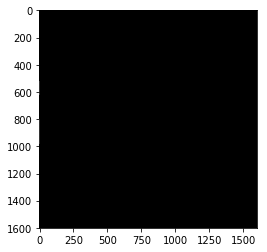

True


In [26]:
sl = imread('slice5.tif')
sl = sl.astype(np.bool)
plt.imshow(sl, cmap='gray')
plt.show()
print(sl.max())

*************************************************************************


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


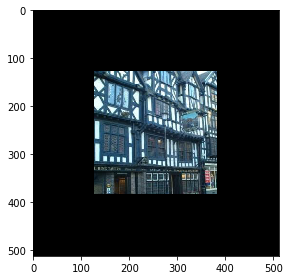

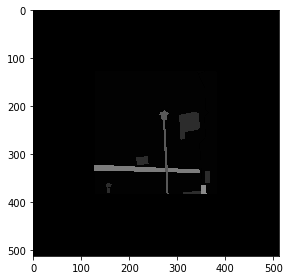

object list [  2   3  44  88 124 139]
Slice n: 1


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


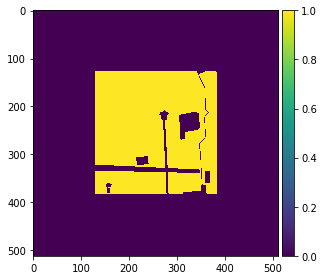

Slice n: 2


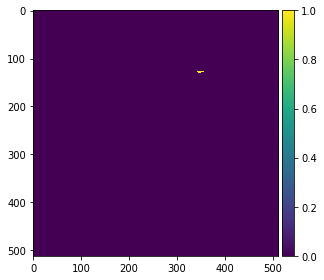

Slice n: 43


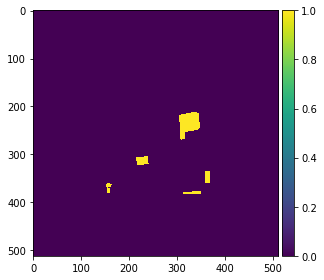

Slice n: 87


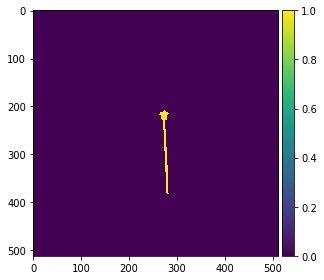

Slice n: 123


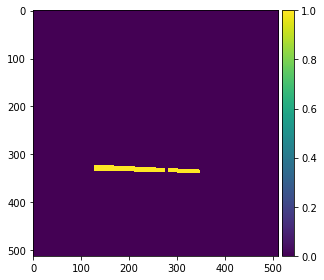

Slice n: 138


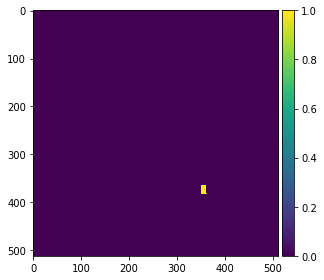

In [39]:
import numpy as np
from skimage.io import imread, imshow
import os

from matplotlib import pyplot as plt
%matplotlib inline

class Data_Generator_from_folder2(object):
    def __init__(self, image_path, anno_path, batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_class):
        self.image_path = image_path
        self.anno_path = anno_path
        self.batch_size = batch_size
        self.ids = os.listdir(self.image_path)
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_CHANNELS = IMG_CHANNELS
        self.n_class = n_class
    
    def crop_or_pad(self, IMG, H, W):
        sze = IMG.shape
        h_dif_l = abs(H-sze[0])//2 + abs(H-sze[0])%2
        h_dif_r = abs(H-sze[0])//2

        w_dif_l = abs(W-sze[1])//2 + abs(W-sze[1])%2
        w_dif_r = abs(W-sze[1])//2
        
        if (sze[0]<H and sze[1]<W):
            if len(sze)==3:
                IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (w_dif_l, w_dif_r), (0, 0)), mode='constant', constant_values=0)
            else:
                IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (w_dif_l, w_dif_r)), mode='constant', constant_values=0)
        elif (sze[0]<H or sze[1]<W):
            if (sze[0]<H):
                if len(sze)==3:
                    IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (0, 0), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[:, w_dif_l:sze[1]-w_dif_r, :]
                else:
                    IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[:, w_dif_l:sze[1]-w_dif_r]
            else:
                if len(sze)==3:
                    IMG = np.pad(IMG, ((0, 0), (w_dif_l, w_dif_r), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[h_dif_l:sze[0]-h_dif_r, :, :]
                else:
                    IMG = np.pad(IMG, ((0, 0), (w_dif_l, w_dif_r)), mode='constant', constant_values=0)
                    IMG = IMG[h_dif_l:sze[0]-h_dif_r, :]
        else:
            if len(sze)==3:
                IMG = IMG[h_dif_l:sze[0]-h_dif_r, w_dif_l:sze[1]-w_dif_r, :]
            else:
                IMG = IMG[h_dif_l:sze[0]-h_dif_r, w_dif_l:sze[1]-w_dif_r]
        return IMG
    
    def generator(self):
        while 1:
            for idx in range(0,len(self.ids), self.batch_size):
                ids_ = self.ids[idx:idx+self.batch_size]
                img = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
                mask = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_class), dtype=np.uint8)
                i=0
                for id_ in ids_:
                    img_ = imread(self.image_path + id_)
                    if img_.shape[0] == 3:
                        img_ = np.rollaxis(img_, 3, 1)  
                    
                    img_ = self.crop_or_pad(img_, self.IMG_HEIGHT, self.IMG_WIDTH)
                    img[i] = img_
                    
                    print("*************************************************************************")
                    imshow(img[btch])
                    plt.show()
        
                    mask_ = imread(self.anno_path + id_.split('.')[0] + '.png')
                    
                    mask_ = self.crop_or_pad(mask_, self.IMG_HEIGHT, self.IMG_WIDTH)
                    
                    imshow(mask_)
                    plt.show()
                    exist_class = np.unique(mask_)
                    if exist_class[0] == 0:
                        exist_class = np.delete(exist_class,0)
                    print("object list", exist_class)
                    for cls in exist_class:
                        class_mask = np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH), dtype=np.uint8)
                        class_mask[mask_ == cls] = 1
                        mask[i,:,:, cls-1] = class_mask
                    i += 1
                yield img, mask

                
IMAGE_PATH_TRAIN = '/media/instadeep/DATA/projects/sceneparsing_MIT/images/training/'
ANNO_PATH_TRAIN = '/media/instadeep/DATA/projects/sceneparsing_MIT/annotations/training/'
N_CLASS = 150
BATCH_SIZE = 1
IMG_WIDTH=512
IMG_HEIGHT=512
IMG_CHANNELS = 3


training_generator = Data_Generator_from_folder2(IMAGE_PATH_TRAIN, ANNO_PATH_TRAIN, BATCH_SIZE,
                                                 IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, N_CLASS)

for img, mask in training_generator.generator():
    for btch in range(BATCH_SIZE): 
        for i in range(150):
            if len(np.nonzero(mask[btch,:,:,i])[0]):
                print('Slice n:', i)
                imshow(mask[btch,:,:,i])
                plt.show()
    break

In [41]:
import numpy as np
from skimage.io import imread, imshow
import os

from matplotlib import pyplot as plt
%matplotlib inline

class Data_Generator_from_folder2(object):
    def __init__(self, image_path, anno_path, batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, n_class):
        self.image_path = image_path
        self.anno_path = anno_path
        self.batch_size = batch_size
        self.ids = os.listdir(self.image_path)
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.IMG_CHANNELS = IMG_CHANNELS
        self.n_class = n_class
    
    def crop_or_pad(self, IMG, H, W):
        sze = IMG.shape
        h_dif_l = abs(H-sze[0])//2 + abs(H-sze[0])%2
        h_dif_r = abs(H-sze[0])//2

        w_dif_l = abs(W-sze[1])//2 + abs(W-sze[1])%2
        w_dif_r = abs(W-sze[1])//2
        
        if (sze[0]<H and sze[1]<W):
            if len(sze)==3:
                IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (w_dif_l, w_dif_r), (0, 0)), mode='constant', constant_values=0)
            else:
                IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (w_dif_l, w_dif_r)), mode='constant', constant_values=0)
        elif (sze[0]<H or sze[1]<W):
            if (sze[0]<H):
                if len(sze)==3:
                    IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (0, 0), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[:, w_dif_l:sze[1]-w_dif_r, :]
                else:
                    IMG = np.pad(IMG, ((h_dif_l, h_dif_r), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[:, w_dif_l:sze[1]-w_dif_r]
            else:
                if len(sze)==3:
                    IMG = np.pad(IMG, ((0, 0), (w_dif_l, w_dif_r), (0, 0)), mode='constant', constant_values=0)
                    IMG = IMG[h_dif_l:sze[0]-h_dif_r, :, :]
                else:
                    IMG = np.pad(IMG, ((0, 0), (w_dif_l, w_dif_r)), mode='constant', constant_values=0)
                    IMG = IMG[h_dif_l:sze[0]-h_dif_r, :]
        else:
            if len(sze)==3:
                IMG = IMG[h_dif_l:sze[0]-h_dif_r, w_dif_l:sze[1]-w_dif_r, :]
            else:
                IMG = IMG[h_dif_l:sze[0]-h_dif_r, w_dif_l:sze[1]-w_dif_r]
        return IMG
    
    def generator(self):
        while 1:
            for idx in range(0,len(self.ids), self.batch_size):
                ids_ = self.ids[idx:idx+self.batch_size]
                img = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.IMG_CHANNELS), dtype=np.uint8)
                mask = np.zeros((self.batch_size, self.IMG_HEIGHT, self.IMG_WIDTH, self.n_class), dtype=np.uint8)
                i=0
                for id_ in ids_:
                    img_ = imread(self.image_path + id_)
                    print(id_)
                    if img_.shape[0] == 3:
                        img_ = np.rollaxis(img_, 3, 1)  
                    img_ = self.crop_or_pad(img_, self.IMG_HEIGHT, self.IMG_WIDTH)
                    img[i] = img_
                    mask_ = imread(self.anno_path + id_.split('.')[0] + '.png')
                    mask_ = self.crop_or_pad(mask_, self.IMG_HEIGHT, self.IMG_WIDTH)
                    exist_class = np.unique(mask_)
                    if exist_class[0] == 0:
                        exist_class = np.delete(exist_class,0)
                    for cls in exist_class:
                        class_mask = np.zeros((self.IMG_HEIGHT, self.IMG_WIDTH), dtype=np.uint8)
                        class_mask[mask_ == cls] = 1
                        mask[i,:,:, cls-1] = class_mask
                    i += 1
                yield img, mask

                
IMAGE_PATH_TRAIN = '/media/instadeep/DATA/projects/sceneparsing_MIT/images/training/'
ANNO_PATH_TRAIN = '/media/instadeep/DATA/projects/sceneparsing_MIT/annotations/training/'
N_CLASS = 150
BATCH_SIZE = 1
IMG_WIDTH=512
IMG_HEIGHT=512
IMG_CHANNELS = 3


training_generator = Data_Generator_from_folder2(IMAGE_PATH_TRAIN, ANNO_PATH_TRAIN, BATCH_SIZE,
                                                 IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, N_CLASS)

for img, mask in training_generator.generator():
    pass

ADE_train_00004658.jpg
ADE_train_00016075.jpg
ADE_train_00015821.jpg
ADE_train_00008088.jpg
ADE_train_00016724.jpg
ADE_train_00006372.jpg
ADE_train_00017362.jpg
ADE_train_00004934.jpg
ADE_train_00007295.jpg
ADE_train_00008491.jpg
ADE_train_00008804.jpg
ADE_train_00009265.jpg
ADE_train_00001257.jpg
ADE_train_00015406.jpg
ADE_train_00003760.jpg
ADE_train_00001220.jpg
ADE_train_00005048.jpg
ADE_train_00014083.jpg
ADE_train_00012650.jpg
ADE_train_00015179.jpg
ADE_train_00015393.jpg
ADE_train_00009672.jpg
ADE_train_00016050.jpg
ADE_train_00016552.jpg
ADE_train_00015520.jpg
ADE_train_00014236.jpg
ADE_train_00005227.jpg
ADE_train_00009755.jpg
ADE_train_00016966.jpg
ADE_train_00013633.jpg
ADE_train_00015289.jpg
ADE_train_00017155.jpg
ADE_train_00014290.jpg
ADE_train_00002774.jpg
ADE_train_00011827.jpg
ADE_train_00014055.jpg
ADE_train_00017822.jpg
ADE_train_00010212.jpg
ADE_train_00016740.jpg
ADE_train_00003957.jpg
ADE_train_00000035.jpg
ADE_train_00004069.jpg
ADE_train_00005921.jpg
ADE_train_0

ADE_train_00004540.jpg
ADE_train_00003350.jpg
ADE_train_00016981.jpg
ADE_train_00005916.jpg
ADE_train_00002964.jpg
ADE_train_00018271.jpg
ADE_train_00001648.jpg
ADE_train_00003662.jpg
ADE_train_00013540.jpg
ADE_train_00012893.jpg
ADE_train_00013248.jpg
ADE_train_00011141.jpg
ADE_train_00007522.jpg
ADE_train_00008967.jpg
ADE_train_00000906.jpg
ADE_train_00002932.jpg
ADE_train_00007001.jpg
ADE_train_00009093.jpg
ADE_train_00007570.jpg
ADE_train_00006690.jpg
ADE_train_00017014.jpg
ADE_train_00018735.jpg
ADE_train_00011759.jpg
ADE_train_00009833.jpg
ADE_train_00013985.jpg
ADE_train_00001637.jpg
ADE_train_00001272.jpg
ADE_train_00005147.jpg
ADE_train_00015368.jpg
ADE_train_00012422.jpg
ADE_train_00011530.jpg
ADE_train_00007135.jpg
ADE_train_00015656.jpg
ADE_train_00012760.jpg
ADE_train_00014883.jpg
ADE_train_00017506.jpg
ADE_train_00018098.jpg
ADE_train_00019627.jpg
ADE_train_00017483.jpg
ADE_train_00018640.jpg
ADE_train_00004983.jpg
ADE_train_00016335.jpg
ADE_train_00007210.jpg
ADE_train_0

ADE_train_00019523.jpg
ADE_train_00006907.jpg
ADE_train_00005059.jpg
ADE_train_00017981.jpg
ADE_train_00019000.jpg
ADE_train_00013696.jpg
ADE_train_00012392.jpg
ADE_train_00013793.jpg
ADE_train_00015586.jpg
ADE_train_00001994.jpg
ADE_train_00002908.jpg
ADE_train_00007093.jpg
ADE_train_00017814.jpg
ADE_train_00013208.jpg
ADE_train_00004692.jpg
ADE_train_00001940.jpg
ADE_train_00014304.jpg
ADE_train_00018031.jpg
ADE_train_00005613.jpg
ADE_train_00003756.jpg
ADE_train_00019402.jpg
ADE_train_00011539.jpg
ADE_train_00010334.jpg
ADE_train_00002868.jpg
ADE_train_00014754.jpg
ADE_train_00000390.jpg
ADE_train_00004792.jpg
ADE_train_00006881.jpg
ADE_train_00004489.jpg
ADE_train_00011455.jpg
ADE_train_00007725.jpg
ADE_train_00008381.jpg
ADE_train_00000762.jpg
ADE_train_00020118.jpg
ADE_train_00011781.jpg
ADE_train_00013047.jpg
ADE_train_00003630.jpg
ADE_train_00016661.jpg
ADE_train_00001496.jpg
ADE_train_00001155.jpg
ADE_train_00004772.jpg
ADE_train_00011371.jpg
ADE_train_00012331.jpg
ADE_train_0

ADE_train_00000848.jpg
ADE_train_00002755.jpg
ADE_train_00001312.jpg
ADE_train_00018276.jpg
ADE_train_00012166.jpg
ADE_train_00011030.jpg
ADE_train_00005467.jpg
ADE_train_00018487.jpg
ADE_train_00002229.jpg
ADE_train_00011677.jpg
ADE_train_00016108.jpg
ADE_train_00000925.jpg
ADE_train_00013777.jpg
ADE_train_00000773.jpg
ADE_train_00007436.jpg
ADE_train_00001159.jpg
ADE_train_00005608.jpg
ADE_train_00009983.jpg
ADE_train_00013611.jpg
ADE_train_00002670.jpg
ADE_train_00014017.jpg
ADE_train_00002119.jpg
ADE_train_00015152.jpg
ADE_train_00006588.jpg
ADE_train_00009546.jpg
ADE_train_00002559.jpg
ADE_train_00005730.jpg
ADE_train_00004685.jpg
ADE_train_00013916.jpg
ADE_train_00016705.jpg
ADE_train_00015479.jpg
ADE_train_00001712.jpg
ADE_train_00004011.jpg
ADE_train_00012594.jpg
ADE_train_00006388.jpg
ADE_train_00004208.jpg
ADE_train_00007882.jpg
ADE_train_00019122.jpg
ADE_train_00011409.jpg
ADE_train_00008263.jpg
ADE_train_00011288.jpg
ADE_train_00016845.jpg
ADE_train_00001572.jpg
ADE_train_0

ADE_train_00019608.jpg
ADE_train_00011773.jpg
ADE_train_00010673.jpg
ADE_train_00019367.jpg
ADE_train_00002465.jpg
ADE_train_00012333.jpg
ADE_train_00008102.jpg
ADE_train_00016945.jpg
ADE_train_00019998.jpg
ADE_train_00008688.jpg
ADE_train_00005109.jpg
ADE_train_00009729.jpg
ADE_train_00008631.jpg
ADE_train_00002350.jpg
ADE_train_00015375.jpg
ADE_train_00013053.jpg
ADE_train_00007294.jpg
ADE_train_00007393.jpg
ADE_train_00016036.jpg
ADE_train_00017943.jpg
ADE_train_00013201.jpg
ADE_train_00005964.jpg
ADE_train_00016052.jpg
ADE_train_00004463.jpg
ADE_train_00003757.jpg
ADE_train_00004245.jpg
ADE_train_00012582.jpg
ADE_train_00019288.jpg
ADE_train_00007413.jpg
ADE_train_00018541.jpg
ADE_train_00004055.jpg
ADE_train_00006926.jpg
ADE_train_00001179.jpg
ADE_train_00010376.jpg
ADE_train_00016938.jpg
ADE_train_00016711.jpg
ADE_train_00013678.jpg
ADE_train_00017110.jpg
ADE_train_00013942.jpg
ADE_train_00012168.jpg
ADE_train_00016838.jpg
ADE_train_00010595.jpg
ADE_train_00020115.jpg
ADE_train_0

ADE_train_00018306.jpg
ADE_train_00002083.jpg
ADE_train_00019060.jpg
ADE_train_00000718.jpg
ADE_train_00004486.jpg
ADE_train_00004589.jpg
ADE_train_00005433.jpg
ADE_train_00003306.jpg
ADE_train_00019578.jpg
ADE_train_00020067.jpg
ADE_train_00018104.jpg
ADE_train_00019796.jpg
ADE_train_00006033.jpg
ADE_train_00008206.jpg
ADE_train_00010472.jpg
ADE_train_00020175.jpg
ADE_train_00003933.jpg
ADE_train_00016037.jpg
ADE_train_00001986.jpg
ADE_train_00002314.jpg
ADE_train_00017423.jpg
ADE_train_00015730.jpg
ADE_train_00019510.jpg
ADE_train_00016663.jpg
ADE_train_00001977.jpg
ADE_train_00009499.jpg
ADE_train_00015554.jpg
ADE_train_00007037.jpg
ADE_train_00004921.jpg
ADE_train_00003871.jpg
ADE_train_00011307.jpg
ADE_train_00006762.jpg
ADE_train_00014697.jpg
ADE_train_00000568.jpg
ADE_train_00017281.jpg
ADE_train_00014581.jpg
ADE_train_00004510.jpg
ADE_train_00008021.jpg
ADE_train_00011845.jpg
ADE_train_00007355.jpg
ADE_train_00007182.jpg
ADE_train_00010790.jpg
ADE_train_00008984.jpg
ADE_train_0

ADE_train_00001508.jpg
ADE_train_00008451.jpg
ADE_train_00004738.jpg
ADE_train_00015222.jpg
ADE_train_00014098.jpg
ADE_train_00001504.jpg
ADE_train_00019712.jpg
ADE_train_00002146.jpg
ADE_train_00017189.jpg
ADE_train_00000526.jpg
ADE_train_00001659.jpg
ADE_train_00011499.jpg
ADE_train_00010638.jpg
ADE_train_00002952.jpg
ADE_train_00010918.jpg
ADE_train_00005306.jpg
ADE_train_00012379.jpg
ADE_train_00000757.jpg
ADE_train_00004839.jpg
ADE_train_00003296.jpg
ADE_train_00016638.jpg
ADE_train_00003524.jpg
ADE_train_00001517.jpg
ADE_train_00016270.jpg
ADE_train_00003599.jpg
ADE_train_00001680.jpg
ADE_train_00003123.jpg
ADE_train_00008523.jpg
ADE_train_00001585.jpg
ADE_train_00008768.jpg
ADE_train_00005891.jpg
ADE_train_00014860.jpg
ADE_train_00000163.jpg
ADE_train_00016414.jpg
ADE_train_00018993.jpg
ADE_train_00017586.jpg
ADE_train_00007197.jpg
ADE_train_00007167.jpg
ADE_train_00019533.jpg
ADE_train_00019003.jpg
ADE_train_00014591.jpg
ADE_train_00011198.jpg
ADE_train_00012028.jpg
ADE_train_0

ADE_train_00010562.jpg
ADE_train_00012374.jpg
ADE_train_00006655.jpg
ADE_train_00014241.jpg
ADE_train_00010583.jpg
ADE_train_00002757.jpg
ADE_train_00000402.jpg
ADE_train_00012810.jpg
ADE_train_00018924.jpg
ADE_train_00003266.jpg
ADE_train_00016316.jpg
ADE_train_00015054.jpg
ADE_train_00004624.jpg
ADE_train_00009188.jpg
ADE_train_00017034.jpg
ADE_train_00019675.jpg
ADE_train_00018082.jpg
ADE_train_00012937.jpg
ADE_train_00005642.jpg
ADE_train_00012931.jpg
ADE_train_00015672.jpg
ADE_train_00008089.jpg
ADE_train_00002156.jpg
ADE_train_00010412.jpg
ADE_train_00003474.jpg
ADE_train_00009783.jpg
ADE_train_00014509.jpg
ADE_train_00009436.jpg
ADE_train_00000607.jpg
ADE_train_00014547.jpg
ADE_train_00014397.jpg
ADE_train_00015899.jpg
ADE_train_00017104.jpg
ADE_train_00017750.jpg
ADE_train_00017727.jpg
ADE_train_00010656.jpg
ADE_train_00012061.jpg
ADE_train_00006621.jpg
ADE_train_00005566.jpg
ADE_train_00009687.jpg
ADE_train_00014272.jpg
ADE_train_00019686.jpg
ADE_train_00012014.jpg
ADE_train_0

ADE_train_00010647.jpg
ADE_train_00018920.jpg
ADE_train_00010880.jpg
ADE_train_00003363.jpg
ADE_train_00007071.jpg
ADE_train_00008048.jpg
ADE_train_00006093.jpg
ADE_train_00007327.jpg
ADE_train_00015382.jpg
ADE_train_00009543.jpg
ADE_train_00018810.jpg
ADE_train_00013898.jpg
ADE_train_00004123.jpg
ADE_train_00015624.jpg
ADE_train_00010282.jpg
ADE_train_00019415.jpg
ADE_train_00010661.jpg
ADE_train_00014932.jpg
ADE_train_00008195.jpg
ADE_train_00002882.jpg
ADE_train_00013569.jpg
ADE_train_00001376.jpg
ADE_train_00004543.jpg
ADE_train_00012910.jpg
ADE_train_00012481.jpg
ADE_train_00010408.jpg
ADE_train_00012309.jpg
ADE_train_00018270.jpg
ADE_train_00012427.jpg
ADE_train_00012434.jpg
ADE_train_00001586.jpg
ADE_train_00013929.jpg
ADE_train_00002200.jpg
ADE_train_00016155.jpg
ADE_train_00016237.jpg
ADE_train_00006121.jpg
ADE_train_00009971.jpg
ADE_train_00012324.jpg
ADE_train_00015288.jpg
ADE_train_00010231.jpg
ADE_train_00008380.jpg
ADE_train_00002883.jpg
ADE_train_00000598.jpg
ADE_train_0

ADE_train_00017277.jpg
ADE_train_00012608.jpg
ADE_train_00006234.jpg
ADE_train_00000919.jpg
ADE_train_00002448.jpg
ADE_train_00017370.jpg
ADE_train_00009733.jpg
ADE_train_00009043.jpg
ADE_train_00003812.jpg
ADE_train_00018589.jpg
ADE_train_00019814.jpg
ADE_train_00001772.jpg
ADE_train_00019260.jpg
ADE_train_00008710.jpg
ADE_train_00017754.jpg
ADE_train_00011086.jpg
ADE_train_00008040.jpg
ADE_train_00006801.jpg
ADE_train_00000630.jpg
ADE_train_00011848.jpg
ADE_train_00007955.jpg
ADE_train_00018482.jpg
ADE_train_00009074.jpg
ADE_train_00003446.jpg
ADE_train_00016853.jpg
ADE_train_00005534.jpg
ADE_train_00005031.jpg
ADE_train_00001285.jpg
ADE_train_00005052.jpg
ADE_train_00008844.jpg
ADE_train_00001226.jpg
ADE_train_00008917.jpg
ADE_train_00011591.jpg
ADE_train_00016197.jpg
ADE_train_00013238.jpg
ADE_train_00018671.jpg
ADE_train_00000264.jpg
ADE_train_00015206.jpg
ADE_train_00005852.jpg
ADE_train_00003732.jpg
ADE_train_00001428.jpg
ADE_train_00011951.jpg
ADE_train_00019945.jpg
ADE_train_0

ADE_train_00009545.jpg
ADE_train_00019565.jpg
ADE_train_00011819.jpg
ADE_train_00013470.jpg
ADE_train_00000272.jpg
ADE_train_00011636.jpg
ADE_train_00005295.jpg
ADE_train_00005604.jpg
ADE_train_00018305.jpg
ADE_train_00005403.jpg
ADE_train_00006145.jpg
ADE_train_00002005.jpg
ADE_train_00014137.jpg
ADE_train_00014005.jpg
ADE_train_00015292.jpg
ADE_train_00004219.jpg
ADE_train_00017618.jpg
ADE_train_00012461.jpg
ADE_train_00014694.jpg
ADE_train_00003921.jpg
ADE_train_00001294.jpg
ADE_train_00013530.jpg
ADE_train_00000240.jpg
ADE_train_00009360.jpg
ADE_train_00001938.jpg
ADE_train_00018943.jpg
ADE_train_00014739.jpg
ADE_train_00010245.jpg
ADE_train_00015917.jpg
ADE_train_00008721.jpg
ADE_train_00016337.jpg
ADE_train_00016354.jpg
ADE_train_00012891.jpg
ADE_train_00011609.jpg
ADE_train_00009031.jpg
ADE_train_00009661.jpg
ADE_train_00011405.jpg
ADE_train_00000834.jpg
ADE_train_00009529.jpg
ADE_train_00016539.jpg
ADE_train_00015183.jpg
ADE_train_00017753.jpg
ADE_train_00015036.jpg
ADE_train_0

ADE_train_00005721.jpg
ADE_train_00008534.jpg
ADE_train_00017872.jpg
ADE_train_00018193.jpg
ADE_train_00015615.jpg
ADE_train_00002302.jpg
ADE_train_00016299.jpg
ADE_train_00015481.jpg
ADE_train_00001032.jpg
ADE_train_00013235.jpg
ADE_train_00008763.jpg
ADE_train_00018147.jpg
ADE_train_00020077.jpg
ADE_train_00002810.jpg
ADE_train_00010145.jpg
ADE_train_00016855.jpg
ADE_train_00011349.jpg
ADE_train_00017188.jpg
ADE_train_00011426.jpg
ADE_train_00005294.jpg
ADE_train_00016488.jpg
ADE_train_00014669.jpg
ADE_train_00019648.jpg
ADE_train_00018638.jpg
ADE_train_00000664.jpg
ADE_train_00017524.jpg
ADE_train_00019246.jpg
ADE_train_00019134.jpg
ADE_train_00005086.jpg
ADE_train_00004290.jpg
ADE_train_00020106.jpg
ADE_train_00018855.jpg
ADE_train_00010858.jpg
ADE_train_00019171.jpg
ADE_train_00010370.jpg
ADE_train_00011329.jpg
ADE_train_00016387.jpg
ADE_train_00011942.jpg
ADE_train_00017574.jpg
ADE_train_00011232.jpg
ADE_train_00006574.jpg
ADE_train_00007539.jpg
ADE_train_00006929.jpg
ADE_train_0

ADE_train_00002534.jpg
ADE_train_00010458.jpg
ADE_train_00017722.jpg
ADE_train_00018776.jpg
ADE_train_00016255.jpg
ADE_train_00000999.jpg
ADE_train_00017513.jpg
ADE_train_00019299.jpg
ADE_train_00009555.jpg
ADE_train_00008275.jpg
ADE_train_00005773.jpg
ADE_train_00015107.jpg
ADE_train_00010295.jpg
ADE_train_00014848.jpg
ADE_train_00003113.jpg
ADE_train_00009869.jpg
ADE_train_00016210.jpg
ADE_train_00017690.jpg
ADE_train_00002838.jpg
ADE_train_00007142.jpg
ADE_train_00007536.jpg
ADE_train_00013243.jpg
ADE_train_00016218.jpg
ADE_train_00017421.jpg
ADE_train_00004454.jpg
ADE_train_00015578.jpg
ADE_train_00008690.jpg
ADE_train_00010799.jpg
ADE_train_00014019.jpg
ADE_train_00008960.jpg
ADE_train_00003241.jpg
ADE_train_00005445.jpg
ADE_train_00012361.jpg
ADE_train_00012483.jpg
ADE_train_00018518.jpg
ADE_train_00008542.jpg
ADE_train_00008990.jpg
ADE_train_00012687.jpg
ADE_train_00014803.jpg
ADE_train_00013119.jpg
ADE_train_00002750.jpg
ADE_train_00009217.jpg
ADE_train_00017739.jpg
ADE_train_0

ADE_train_00010612.jpg
ADE_train_00001547.jpg
ADE_train_00016060.jpg
ADE_train_00014050.jpg
ADE_train_00001291.jpg
ADE_train_00004847.jpg
ADE_train_00010244.jpg
ADE_train_00012327.jpg
ADE_train_00007644.jpg
ADE_train_00001025.jpg
ADE_train_00008808.jpg
ADE_train_00011968.jpg
ADE_train_00009002.jpg
ADE_train_00015076.jpg
ADE_train_00018064.jpg
ADE_train_00018686.jpg
ADE_train_00017059.jpg
ADE_train_00000800.jpg
ADE_train_00018768.jpg
ADE_train_00000975.jpg
ADE_train_00007640.jpg
ADE_train_00006080.jpg
ADE_train_00007328.jpg
ADE_train_00001008.jpg
ADE_train_00019454.jpg
ADE_train_00000732.jpg
ADE_train_00004312.jpg
ADE_train_00007800.jpg
ADE_train_00019854.jpg
ADE_train_00016680.jpg
ADE_train_00002272.jpg
ADE_train_00007018.jpg
ADE_train_00002080.jpg
ADE_train_00017496.jpg
ADE_train_00018812.jpg
ADE_train_00011150.jpg
ADE_train_00005885.jpg
ADE_train_00016521.jpg
ADE_train_00004043.jpg
ADE_train_00000932.jpg
ADE_train_00002359.jpg
ADE_train_00002769.jpg
ADE_train_00003195.jpg
ADE_train_0

ADE_train_00007730.jpg
ADE_train_00013012.jpg
ADE_train_00000050.jpg
ADE_train_00000937.jpg
ADE_train_00000939.jpg
ADE_train_00002989.jpg
ADE_train_00005753.jpg
ADE_train_00008673.jpg
ADE_train_00002132.jpg
ADE_train_00016432.jpg
ADE_train_00007389.jpg
ADE_train_00011492.jpg
ADE_train_00008569.jpg
ADE_train_00016023.jpg
ADE_train_00005954.jpg
ADE_train_00009689.jpg
ADE_train_00007098.jpg
ADE_train_00003103.jpg
ADE_train_00007903.jpg
ADE_train_00001060.jpg
ADE_train_00004822.jpg
ADE_train_00008210.jpg
ADE_train_00005454.jpg
ADE_train_00004229.jpg
ADE_train_00005814.jpg
ADE_train_00005605.jpg
ADE_train_00013802.jpg
ADE_train_00016437.jpg
ADE_train_00004536.jpg
ADE_train_00019139.jpg
ADE_train_00017593.jpg
ADE_train_00003263.jpg
ADE_train_00005116.jpg
ADE_train_00002375.jpg
ADE_train_00009693.jpg
ADE_train_00016438.jpg
ADE_train_00001879.jpg
ADE_train_00014026.jpg
ADE_train_00019332.jpg
ADE_train_00009573.jpg
ADE_train_00002669.jpg
ADE_train_00008980.jpg
ADE_train_00018531.jpg
ADE_train_0

ADE_train_00000690.jpg
ADE_train_00009152.jpg
ADE_train_00001187.jpg
ADE_train_00001139.jpg
ADE_train_00001834.jpg
ADE_train_00004336.jpg
ADE_train_00002703.jpg
ADE_train_00011384.jpg
ADE_train_00013892.jpg
ADE_train_00013659.jpg
ADE_train_00018602.jpg
ADE_train_00018722.jpg
ADE_train_00014908.jpg
ADE_train_00002197.jpg
ADE_train_00011746.jpg
ADE_train_00001478.jpg
ADE_train_00011947.jpg
ADE_train_00003376.jpg
ADE_train_00013441.jpg
ADE_train_00013202.jpg
ADE_train_00003523.jpg
ADE_train_00008838.jpg
ADE_train_00002677.jpg
ADE_train_00006545.jpg
ADE_train_00009536.jpg
ADE_train_00019801.jpg
ADE_train_00015098.jpg
ADE_train_00007483.jpg
ADE_train_00010832.jpg
ADE_train_00016002.jpg
ADE_train_00019244.jpg
ADE_train_00018568.jpg
ADE_train_00013363.jpg
ADE_train_00004812.jpg
ADE_train_00019174.jpg
ADE_train_00011045.jpg
ADE_train_00018957.jpg
ADE_train_00000236.jpg
ADE_train_00012046.jpg
ADE_train_00010667.jpg
ADE_train_00003178.jpg
ADE_train_00000896.jpg
ADE_train_00013914.jpg
ADE_train_0

ADE_train_00000334.jpg
ADE_train_00006425.jpg
ADE_train_00018777.jpg
ADE_train_00004431.jpg
ADE_train_00000663.jpg
ADE_train_00015719.jpg
ADE_train_00001014.jpg
ADE_train_00015732.jpg
ADE_train_00019027.jpg
ADE_train_00008835.jpg
ADE_train_00007672.jpg
ADE_train_00019417.jpg
ADE_train_00000176.jpg
ADE_train_00002588.jpg
ADE_train_00004272.jpg
ADE_train_00015834.jpg
ADE_train_00019109.jpg
ADE_train_00015822.jpg
ADE_train_00019001.jpg
ADE_train_00014805.jpg
ADE_train_00017158.jpg
ADE_train_00018260.jpg
ADE_train_00018723.jpg
ADE_train_00015499.jpg
ADE_train_00016116.jpg
ADE_train_00002433.jpg
ADE_train_00010909.jpg
ADE_train_00015885.jpg
ADE_train_00009311.jpg
ADE_train_00001671.jpg
ADE_train_00002228.jpg
ADE_train_00019398.jpg
ADE_train_00013276.jpg
ADE_train_00004238.jpg
ADE_train_00013100.jpg
ADE_train_00003720.jpg
ADE_train_00018191.jpg
ADE_train_00017332.jpg
ADE_train_00004310.jpg
ADE_train_00001532.jpg
ADE_train_00001488.jpg
ADE_train_00010754.jpg
ADE_train_00008986.jpg
ADE_train_0

ADE_train_00011464.jpg
ADE_train_00014696.jpg
ADE_train_00001143.jpg
ADE_train_00002033.jpg
ADE_train_00011334.jpg
ADE_train_00007012.jpg
ADE_train_00016071.jpg
ADE_train_00005572.jpg
ADE_train_00010750.jpg
ADE_train_00004072.jpg
ADE_train_00018996.jpg
ADE_train_00017507.jpg
ADE_train_00007720.jpg
ADE_train_00009515.jpg
ADE_train_00010071.jpg
ADE_train_00011743.jpg
ADE_train_00017372.jpg
ADE_train_00014470.jpg
ADE_train_00018242.jpg
ADE_train_00017468.jpg
ADE_train_00002605.jpg
ADE_train_00003343.jpg
ADE_train_00000419.jpg
ADE_train_00013901.jpg
ADE_train_00011278.jpg
ADE_train_00001568.jpg
ADE_train_00013401.jpg
ADE_train_00014871.jpg
ADE_train_00007115.jpg
ADE_train_00019863.jpg
ADE_train_00006006.jpg
ADE_train_00015954.jpg
ADE_train_00013895.jpg
ADE_train_00008617.jpg
ADE_train_00019678.jpg
ADE_train_00015128.jpg
ADE_train_00001057.jpg
ADE_train_00007913.jpg
ADE_train_00006877.jpg
ADE_train_00004494.jpg
ADE_train_00006366.jpg
ADE_train_00008306.jpg
ADE_train_00009134.jpg
ADE_train_0

ADE_train_00006890.jpg
ADE_train_00018729.jpg
ADE_train_00007051.jpg
ADE_train_00005112.jpg
ADE_train_00010791.jpg
ADE_train_00007296.jpg
ADE_train_00004795.jpg
ADE_train_00008077.jpg
ADE_train_00013776.jpg
ADE_train_00002571.jpg
ADE_train_00001990.jpg
ADE_train_00003060.jpg
ADE_train_00017742.jpg
ADE_train_00007972.jpg
ADE_train_00004869.jpg
ADE_train_00011633.jpg
ADE_train_00002455.jpg
ADE_train_00008840.jpg
ADE_train_00013044.jpg
ADE_train_00011607.jpg
ADE_train_00018341.jpg
ADE_train_00016821.jpg
ADE_train_00001564.jpg
ADE_train_00007568.jpg
ADE_train_00018551.jpg
ADE_train_00012217.jpg
ADE_train_00013518.jpg
ADE_train_00003542.jpg
ADE_train_00014212.jpg
ADE_train_00008238.jpg
ADE_train_00013414.jpg
ADE_train_00005557.jpg
ADE_train_00014310.jpg
ADE_train_00012964.jpg
ADE_train_00009090.jpg
ADE_train_00003995.jpg
ADE_train_00004124.jpg
ADE_train_00003991.jpg
ADE_train_00006341.jpg
ADE_train_00001322.jpg
ADE_train_00000619.jpg
ADE_train_00018971.jpg
ADE_train_00015337.jpg
ADE_train_0

ADE_train_00000431.jpg
ADE_train_00004729.jpg
ADE_train_00006219.jpg
ADE_train_00010340.jpg
ADE_train_00008005.jpg
ADE_train_00009795.jpg
ADE_train_00011153.jpg
ADE_train_00019253.jpg
ADE_train_00001616.jpg
ADE_train_00000204.jpg
ADE_train_00007749.jpg
ADE_train_00003297.jpg
ADE_train_00009492.jpg
ADE_train_00000356.jpg
ADE_train_00012335.jpg
ADE_train_00015110.jpg
ADE_train_00011693.jpg
ADE_train_00018351.jpg
ADE_train_00001888.jpg
ADE_train_00008993.jpg
ADE_train_00002580.jpg
ADE_train_00013457.jpg
ADE_train_00009252.jpg
ADE_train_00005094.jpg
ADE_train_00006899.jpg
ADE_train_00011015.jpg
ADE_train_00001782.jpg
ADE_train_00001324.jpg
ADE_train_00019696.jpg
ADE_train_00005049.jpg
ADE_train_00010897.jpg
ADE_train_00019243.jpg
ADE_train_00003831.jpg
ADE_train_00013496.jpg
ADE_train_00010460.jpg
ADE_train_00017327.jpg
ADE_train_00015633.jpg
ADE_train_00004328.jpg
ADE_train_00017891.jpg
ADE_train_00002692.jpg
ADE_train_00009463.jpg
ADE_train_00004424.jpg
ADE_train_00009112.jpg
ADE_train_0

ADE_train_00013025.jpg
ADE_train_00009491.jpg
ADE_train_00008137.jpg
ADE_train_00004529.jpg
ADE_train_00005249.jpg
ADE_train_00002554.jpg
ADE_train_00009853.jpg
ADE_train_00003513.jpg
ADE_train_00003624.jpg
ADE_train_00000844.jpg
ADE_train_00011711.jpg
ADE_train_00007432.jpg
ADE_train_00008853.jpg
ADE_train_00005206.jpg
ADE_train_00007160.jpg
ADE_train_00018173.jpg
ADE_train_00001835.jpg
ADE_train_00015339.jpg
ADE_train_00007697.jpg
ADE_train_00009004.jpg
ADE_train_00003102.jpg
ADE_train_00003175.jpg
ADE_train_00002322.jpg
ADE_train_00011816.jpg
ADE_train_00005953.jpg
ADE_train_00003897.jpg
ADE_train_00000218.jpg
ADE_train_00010180.jpg
ADE_train_00019713.jpg
ADE_train_00013115.jpg
ADE_train_00017128.jpg
ADE_train_00005914.jpg
ADE_train_00012221.jpg
ADE_train_00004793.jpg
ADE_train_00008094.jpg
ADE_train_00011326.jpg
ADE_train_00016487.jpg
ADE_train_00013589.jpg
ADE_train_00003478.jpg
ADE_train_00010272.jpg
ADE_train_00001605.jpg
ADE_train_00013375.jpg
ADE_train_00016907.jpg
ADE_train_0

ADE_train_00008334.jpg
ADE_train_00005199.jpg
ADE_train_00018171.jpg
ADE_train_00019842.jpg
ADE_train_00001798.jpg
ADE_train_00019802.jpg
ADE_train_00018256.jpg
ADE_train_00003528.jpg
ADE_train_00000740.jpg
ADE_train_00006630.jpg
ADE_train_00006971.jpg
ADE_train_00016522.jpg
ADE_train_00003163.jpg
ADE_train_00009738.jpg
ADE_train_00013236.jpg
ADE_train_00001429.jpg
ADE_train_00009298.jpg
ADE_train_00016726.jpg
ADE_train_00017780.jpg
ADE_train_00005558.jpg
ADE_train_00003993.jpg
ADE_train_00003214.jpg
ADE_train_00006982.jpg
ADE_train_00012342.jpg
ADE_train_00018597.jpg
ADE_train_00017226.jpg
ADE_train_00019374.jpg
ADE_train_00009054.jpg
ADE_train_00008356.jpg
ADE_train_00007364.jpg
ADE_train_00002648.jpg
ADE_train_00006222.jpg
ADE_train_00010317.jpg
ADE_train_00012358.jpg
ADE_train_00005397.jpg
ADE_train_00005860.jpg
ADE_train_00009544.jpg
ADE_train_00003919.jpg
ADE_train_00013157.jpg
ADE_train_00005362.jpg
ADE_train_00009875.jpg
ADE_train_00001862.jpg
ADE_train_00015888.jpg
ADE_train_0

ADE_train_00000067.jpg
ADE_train_00004361.jpg
ADE_train_00008613.jpg
ADE_train_00012798.jpg
ADE_train_00014095.jpg
ADE_train_00014051.jpg
ADE_train_00006537.jpg
ADE_train_00001875.jpg
ADE_train_00003863.jpg
ADE_train_00009899.jpg
ADE_train_00015137.jpg
ADE_train_00016815.jpg
ADE_train_00002859.jpg
ADE_train_00004432.jpg
ADE_train_00002903.jpg
ADE_train_00007693.jpg
ADE_train_00006821.jpg
ADE_train_00013411.jpg
ADE_train_00004995.jpg
ADE_train_00009087.jpg
ADE_train_00002177.jpg
ADE_train_00003614.jpg
ADE_train_00011273.jpg
ADE_train_00011735.jpg
ADE_train_00019214.jpg
ADE_train_00018382.jpg
ADE_train_00001542.jpg
ADE_train_00019793.jpg
ADE_train_00016492.jpg
ADE_train_00003473.jpg
ADE_train_00007815.jpg
ADE_train_00003783.jpg
ADE_train_00006334.jpg
ADE_train_00001576.jpg
ADE_train_00015352.jpg
ADE_train_00013662.jpg
ADE_train_00001762.jpg
ADE_train_00004831.jpg
ADE_train_00015492.jpg
ADE_train_00006730.jpg
ADE_train_00008751.jpg
ADE_train_00014557.jpg
ADE_train_00007407.jpg
ADE_train_0

ADE_train_00003990.jpg
ADE_train_00015657.jpg
ADE_train_00008336.jpg
ADE_train_00001746.jpg
ADE_train_00008026.jpg
ADE_train_00003490.jpg
ADE_train_00012815.jpg
ADE_train_00019115.jpg
ADE_train_00019199.jpg
ADE_train_00014257.jpg
ADE_train_00018823.jpg
ADE_train_00002191.jpg
ADE_train_00017179.jpg
ADE_train_00000378.jpg
ADE_train_00005450.jpg
ADE_train_00018442.jpg
ADE_train_00005304.jpg
ADE_train_00018265.jpg
ADE_train_00007153.jpg
ADE_train_00004989.jpg
ADE_train_00011397.jpg
ADE_train_00000094.jpg
ADE_train_00012354.jpg
ADE_train_00003345.jpg
ADE_train_00003312.jpg
ADE_train_00002260.jpg
ADE_train_00012510.jpg
ADE_train_00000252.jpg
ADE_train_00012389.jpg
ADE_train_00002098.jpg
ADE_train_00018665.jpg
ADE_train_00000179.jpg
ADE_train_00012236.jpg
ADE_train_00005047.jpg
ADE_train_00012396.jpg
ADE_train_00015991.jpg
ADE_train_00010040.jpg
ADE_train_00001197.jpg
ADE_train_00010225.jpg
ADE_train_00007303.jpg
ADE_train_00019606.jpg
ADE_train_00020103.jpg
ADE_train_00003806.jpg
ADE_train_0

ADE_train_00018237.jpg
ADE_train_00012660.jpg
ADE_train_00002372.jpg
ADE_train_00015882.jpg
ADE_train_00002886.jpg
ADE_train_00006271.jpg
ADE_train_00006740.jpg
ADE_train_00008410.jpg
ADE_train_00006449.jpg
ADE_train_00019334.jpg
ADE_train_00011570.jpg
ADE_train_00019671.jpg
ADE_train_00019766.jpg
ADE_train_00003468.jpg
ADE_train_00003426.jpg
ADE_train_00005941.jpg
ADE_train_00013811.jpg
ADE_train_00011206.jpg
ADE_train_00006983.jpg
ADE_train_00001771.jpg
ADE_train_00001718.jpg
ADE_train_00000586.jpg
ADE_train_00004936.jpg
ADE_train_00005896.jpg
ADE_train_00015053.jpg
ADE_train_00012225.jpg
ADE_train_00018291.jpg
ADE_train_00001018.jpg
ADE_train_00017924.jpg
ADE_train_00002594.jpg
ADE_train_00002257.jpg
ADE_train_00001602.jpg
ADE_train_00012210.jpg
ADE_train_00012850.jpg
ADE_train_00012155.jpg
ADE_train_00009725.jpg
ADE_train_00002483.jpg
ADE_train_00003923.jpg
ADE_train_00007636.jpg
ADE_train_00010072.jpg
ADE_train_00001278.jpg
ADE_train_00017285.jpg
ADE_train_00013253.jpg
ADE_train_0

ADE_train_00010278.jpg
ADE_train_00017270.jpg
ADE_train_00011037.jpg
ADE_train_00016729.jpg
ADE_train_00003855.jpg
ADE_train_00004365.jpg
ADE_train_00005581.jpg
ADE_train_00012027.jpg
ADE_train_00000695.jpg
ADE_train_00013887.jpg
ADE_train_00009808.jpg
ADE_train_00018921.jpg
ADE_train_00014211.jpg
ADE_train_00010241.jpg
ADE_train_00013020.jpg
ADE_train_00014555.jpg
ADE_train_00012268.jpg
ADE_train_00008299.jpg
ADE_train_00003506.jpg
ADE_train_00013871.jpg
ADE_train_00000054.jpg
ADE_train_00000063.jpg
ADE_train_00007936.jpg
ADE_train_00001733.jpg
ADE_train_00012072.jpg
ADE_train_00007934.jpg
ADE_train_00004607.jpg
ADE_train_00012763.jpg
ADE_train_00015055.jpg
ADE_train_00013725.jpg
ADE_train_00013527.jpg
ADE_train_00012054.jpg
ADE_train_00008943.jpg
ADE_train_00008925.jpg
ADE_train_00020051.jpg
ADE_train_00016863.jpg
ADE_train_00013977.jpg
ADE_train_00017903.jpg
ADE_train_00019887.jpg
ADE_train_00016998.jpg
ADE_train_00006733.jpg
ADE_train_00010849.jpg
ADE_train_00009952.jpg
ADE_train_0

ADE_train_00006119.jpg
ADE_train_00005220.jpg
ADE_train_00011966.jpg
ADE_train_00019870.jpg
ADE_train_00008584.jpg
ADE_train_00015880.jpg
ADE_train_00020197.jpg
ADE_train_00001617.jpg
ADE_train_00011041.jpg
ADE_train_00008126.jpg
ADE_train_00010812.jpg
ADE_train_00020068.jpg
ADE_train_00019748.jpg
ADE_train_00014489.jpg
ADE_train_00016279.jpg
ADE_train_00012923.jpg
ADE_train_00015059.jpg
ADE_train_00010419.jpg
ADE_train_00016708.jpg
ADE_train_00015987.jpg
ADE_train_00004158.jpg
ADE_train_00009038.jpg
ADE_train_00004343.jpg
ADE_train_00017450.jpg
ADE_train_00001509.jpg
ADE_train_00018779.jpg
ADE_train_00007411.jpg
ADE_train_00017621.jpg
ADE_train_00019312.jpg
ADE_train_00012860.jpg
ADE_train_00012247.jpg
ADE_train_00010912.jpg
ADE_train_00010931.jpg
ADE_train_00017606.jpg
ADE_train_00012489.jpg
ADE_train_00016224.jpg
ADE_train_00001283.jpg
ADE_train_00017830.jpg
ADE_train_00009050.jpg
ADE_train_00016712.jpg
ADE_train_00001424.jpg
ADE_train_00018751.jpg
ADE_train_00015381.jpg
ADE_train_0

ADE_train_00019646.jpg
ADE_train_00002486.jpg
ADE_train_00016851.jpg
ADE_train_00007371.jpg
ADE_train_00004514.jpg
ADE_train_00016493.jpg
ADE_train_00003012.jpg
ADE_train_00002625.jpg
ADE_train_00001823.jpg
ADE_train_00013769.jpg
ADE_train_00006072.jpg
ADE_train_00015755.jpg
ADE_train_00015831.jpg
ADE_train_00005958.jpg
ADE_train_00000966.jpg
ADE_train_00007465.jpg
ADE_train_00005236.jpg
ADE_train_00014399.jpg
ADE_train_00001266.jpg
ADE_train_00017748.jpg
ADE_train_00016891.jpg
ADE_train_00012768.jpg
ADE_train_00002130.jpg
ADE_train_00009123.jpg
ADE_train_00009640.jpg
ADE_train_00010505.jpg
ADE_train_00007915.jpg
ADE_train_00001129.jpg
ADE_train_00001951.jpg
ADE_train_00007925.jpg
ADE_train_00013648.jpg
ADE_train_00002641.jpg
ADE_train_00006478.jpg
ADE_train_00008521.jpg
ADE_train_00008222.jpg
ADE_train_00005230.jpg
ADE_train_00009204.jpg
ADE_train_00006122.jpg
ADE_train_00016252.jpg
ADE_train_00005514.jpg
ADE_train_00013809.jpg
ADE_train_00015029.jpg
ADE_train_00010254.jpg
ADE_train_0

ADE_train_00013962.jpg
ADE_train_00009898.jpg
ADE_train_00019697.jpg
ADE_train_00008256.jpg
ADE_train_00007521.jpg
ADE_train_00019475.jpg
ADE_train_00017249.jpg
ADE_train_00012902.jpg
ADE_train_00011611.jpg
ADE_train_00016009.jpg
ADE_train_00003205.jpg
ADE_train_00001740.jpg
ADE_train_00004668.jpg
ADE_train_00007840.jpg
ADE_train_00012868.jpg
ADE_train_00002390.jpg
ADE_train_00001087.jpg
ADE_train_00009115.jpg
ADE_train_00014306.jpg
ADE_train_00002236.jpg
ADE_train_00002610.jpg
ADE_train_00011613.jpg
ADE_train_00016066.jpg
ADE_train_00019088.jpg
ADE_train_00011327.jpg
ADE_train_00011549.jpg
ADE_train_00004381.jpg
ADE_train_00019693.jpg
ADE_train_00019061.jpg
ADE_train_00001211.jpg
ADE_train_00013150.jpg
ADE_train_00004572.jpg
ADE_train_00003588.jpg
ADE_train_00001845.jpg
ADE_train_00018888.jpg
ADE_train_00020003.jpg
ADE_train_00006062.jpg
ADE_train_00001914.jpg
ADE_train_00010637.jpg
ADE_train_00001745.jpg
ADE_train_00001127.jpg
ADE_train_00001037.jpg
ADE_train_00005528.jpg
ADE_train_0

ValueError: could not broadcast input array from shape (512,512) into shape (512,512,3)

In [7]:
import os
import numpy as np
from scipy.misc import imsave


IMAGE_PATH_TRAIN = '/media/instadeep/DATA/projects/image_datasets/iccv09Data/images/'
LABS_PATH_TRAIN = '/media/instadeep/DATA/projects/image_datasets/iccv09Data/labels/'
ANNO_PATH_TRAIN = '/media/instadeep/DATA/projects/image_datasets/iccv09Data/annotations/'
ids = os.listdir(IMAGE_PATH_TRAIN)
dist_list = []
for id_ in ids:
    mask_ = np.loadtxt(LABS_PATH_TRAIN + id_.split('.')[0] + '.regions.txt')
    mask_[mask_==-1] = 8
    mask_ = mask_.astype(np.uint8)
    imsave(ANNO_PATH_TRAIN + id_.split('.')[0] + '.png', mask_)
    

/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [11]:
import os, random
from shutil import copyfile

IMAGE_PATH_TRAIN = '/media/instadeep/DATA/projects/image_datasets/iccv09Data/images/'
ANNO_PATH_TRAIN = '/media/instadeep/DATA/projects/image_datasets/iccv09Data/annotations/'

ids = os.listdir(IMAGE_PATH_TRAIN)

random.shuffle(ids)

for id_ in ids[0:600]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/image_datasets/iccv09Data/train/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_.split('.')[0] + '.png', '/media/instadeep/DATA/projects/image_datasets/iccv09Data/train/annotation/' + id_.split('.')[0] + '.png')
for id_ in ids[600:700]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/image_datasets/iccv09Data/validation/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_.split('.')[0] + '.png', '/media/instadeep/DATA/projects/image_datasets/iccv09Data/validation/annotation/' + id_.split('.')[0] + '.png')
for id_ in ids[700:715]:
    copyfile(IMAGE_PATH_TRAIN + id_, '/media/instadeep/DATA/projects/image_datasets/iccv09Data/test/image/' + id_)
    copyfile(ANNO_PATH_TRAIN + id_.split('.')[0] + '.png', '/media/instadeep/DATA/projects/image_datasets/iccv09Data/test/annotation/' + id_.split('.')[0] + '.png')
    


In [15]:
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
import numpy as np

image = imread('/media/instadeep/DATA/projects/cube_13B/test/annotation/slice10_blur1_angle0_flipn.png')
print(image.max())

# rimage = resize(image, (400,400))*255

rimage = np.rint(resize(image, (960,960), preserve_range=True)).astype(np.uint8)

print(rimage.max())
print(rimage.shape)






    
    
    

5
5
(960, 960)


/media/instadeep/DATA/miniconda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
